# 数据读入模块

In [1]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [2]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [3]:
train_data['is_judicial']=[0 if pd.isna(i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial']=[0 if pd.isna(i) else 1 for i in test_data['judicial_reason']]

## 处理NAN

In [4]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [5]:
df_train = delnan(train_data)
df_test = delnan(test_data)
df_train.replace(-99,-1,inplace=True)
df_test.replace(-99,-1,inplace=True)

In [6]:
""" for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts()) """


' for i in range(2, 17):\n    print(df_train.iloc[:, i].value_counts()) '

In [7]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [8]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [9]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [10]:
df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [11]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## 设置哪些x作为模型自变量输入

In [12]:
x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col
# x_col为模型读入的自变量列名称


""" x_col=['loan2_3_y',
 'loan1_6',
 'loan1_32',
 'loan1_31',
 'basic_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_15',
 'loan2_5_y',
 'loan1_30',
 'loan1_7',
 'loan1_3',
 'query_1',
 'query_7',
 'loan1_17',
 'query_4',
 'loan1_14',
 'basic_1_y',
 'loan1_21',
 'query_1_y'] """

" x_col=['loan2_3_y',\n 'loan1_6',\n 'loan1_32',\n 'loan1_31',\n 'basic_7',\n 'loan2_4_y',\n 'loan2_3',\n 'loan1_15',\n 'loan2_5_y',\n 'loan1_30',\n 'loan1_7',\n 'loan1_3',\n 'query_1',\n 'query_7',\n 'loan1_17',\n 'query_4',\n 'loan1_14',\n 'basic_1_y',\n 'loan1_21',\n 'query_1_y'] "

In [13]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [14]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [15]:
N = 1000
num_round = 100
local_test_size=1500

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8,0.7, 0.6,0.5]
scale_pos_weight = [1, 3, 6, 10,20, 30]
test_size=[0.3,0.5,0.7]
subsample=[0.7,0.6,0.5,0.4]
par_lambda=[1,1.5,2,3]
alpha=[0,0.2,0.4,0.6,0.8]
min_child_weight=[1,2,3,4,5,6,10]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正地训练集（每次的模型不同）dtrain

In [16]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0

num_seq=list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test=df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test=df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest=xgb.DMatrix(X_local_test,label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        #'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample':random.choice(subsample),
        'alpha':random.choice(alpha),
        'lambda':random.choice(par_lambda),
        'min_child_weight':random.choice(min_child_weight),
        #'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)
    
    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])


    temp_dict={"test_auc":loss,"train_auc":train_loss,'local_test_auc':local_test_loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")

1:0.6981649710371782
2:0.7029849980156768
3:0.6673012318291603
4:0.7221130940137698
5:0.7170061492201121
6:0.7041401553734024
7:0.6945904101020225
8:0.7320438898024336
9:0.706172593285131
10:0.6855096920944361
11:0.6940894224930488
12:0.6960500935617372
13:0.6568333333333334
14:0.693447074730407
15:0.7049094681326576
16:0.6996613259224177
17:0.703056706616199
18:0.6831458165866228
19:0.6718819326740467
20:0.6894567469924296
21:0.7024862162331221
22:0.6969555555555556
23:0.6921905037020224
24:0.6988001470956896
25:0.7320367318106898
26:0.6855048741063545
27:0.7144633160945708
28:0.6839985077500722
29:0.6878897587831079
30:0.6857439451996065
31:0.7170314543364901
32:0.6851704331779407
33:0.6861299612580654
34:0.7096161192748891
35:0.7078091764035338
36:0.7104357636785694
37:0.728460821878244
38:0.740866629407001
39:0.6619780269058296
40:0.6552056810184889
41:0.68378596074409
42:0.4944412790437468
43:0.7183966353998285
44:0.7006264771877337
45:0.675919052175816
46:0.657250010681022
47:0.7

In [17]:
info_df

,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.698165,0.891294,0.723452,0.5,5,0.06,0.8,binary:logistic,1,auc,0.4,0.6,3.0,5,gpu_hist,0
1,0.702985,0.809544,0.711708,0.3,4,0.06,0.6,binary:logistic,1,auc,0.6,0.2,2.0,6,gpu_hist,0
2,0.667301,0.983060,0.699862,0.7,8,0.06,0.6,binary:logistic,20,auc,0.4,0.0,3.0,2,gpu_hist,0
3,0.722113,0.943042,0.708173,0.5,4,0.10,0.8,binary:logistic,6,auc,0.7,0.6,2.0,4,gpu_hist,0
4,0.717006,0.870336,0.725283,0.5,3,0.10,0.7,binary:logistic,3,auc,0.7,0.4,2.0,2,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.665532,0.999896,0.713078,0.7,8,0.10,0.8,binary:logistic,3,auc,0.6,0.6,2.0,2,gpu_hist,0
996,0.718439,0.792303,0.676662,0.3,3,0.06,0.8,binary:logistic,6,auc,0.6,0.8,1.0,10,gpu_hist,0
997,0.685319,0.984790,0.717330,0.7,7,0.10,0.5,binary:logistic,6,auc,0.4,0.6,2.0,10,gpu_hist,0
998,0.692196,0.994901,0.721684,0.5,7,0.10,0.6,binary:logistic,20,auc,0.6,0.4,1.5,4,gpu_hist,0


In [18]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

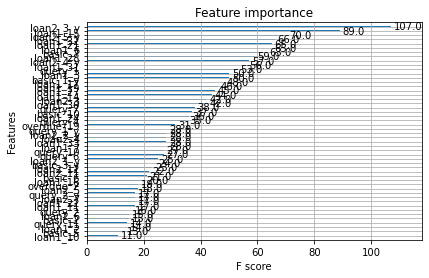

In [19]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [20]:
important_x

['loan2_3_y',
 'loan1_15',
 'loan2_5_y',
 'loan1_32',
 'loan1_21',
 'loan1_6',
 'basic_7',
 'loan1_28',
 'loan2_4_y',
 'loan1_31',
 'query_1',
 'loan1_3',
 'basic_1_y',
 'loan1_17',
 'loan1_19',
 'loan1_27',
 'loan1_14',
 'loan2_3',
 'loan1_30',
 'query_7',
 'basic_10',
 'loan1_24',
 'query_4',
 'overdue_19',
 'query_1_y',
 'loan2_2_y',
 'loan2_4',
 'loan1_33',
 'loan1_7',
 'query_10',
 'query_6',
 'loan2_1_y',
 'basic_3_y',
 'loan2_12',
 'loan2_11',
 'basic_6',
 'loan1_16',
 'overdue_2',
 'loan2_5',
 'query_2_y',
 'loan2_7',
 'loan1_22',
 'loan1_11',
 'query_2',
 'loan2_6',
 'basic_2',
 'query_11',
 'loan1_2',
 'basic_5',
 'loan1_10']

* basic_7:年龄
* 

# 输出模块

In [21]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 100

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后最大AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.7884713897853595
1 0.8014189846831618
2 0.8064904461861585
3 0.8092310844731315
4 0.8073228830490241
5 0.8071179755135496
6 0.809346344961836
7 0.8107806977101584
8 0.8100122944521285
9 0.8101019414988986
10 0.8078607653296449
11 0.8048896060652632
12 0.8044413708314123
13 0.805517135392654
14 0.8053122278571795
15 0.8027124635008452
16 0.8027252702218124
17 0.8020593207315199
18 0.8022642282669945
19 0.8023282618718303
20 0.8026868500589109
21 0.8016495056605707
22 0.8010860099380154
23 0.800586547820296
24 0.8013037241944573
25 0.8019184468008811
26 0.8018416064750782
27 0.8022642282669945
28 0.8022898417089288
29 0.8021745812202244
30 0.8020080938476513
31 0.8020080938476511
32 0.8023666820347318
33 0.8020849341734542
34 0.8020080938476511
35 0.8021617744992572
36 0.8019056400799139
37 0.801764766149275
38 0.8010732032170483
39 0.8006249679831976
40 0.8011244301009169
41 0.8004456738896574
42 0.799882178167102
43 0.7997284975154962
44 0.7999462117719379
45 0.7994211362122842
46 

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？